In [15]:
import numpy as np
from scipy import optimize as opt
from matplotlib import pyplot as plt
from numba import jit
import scipy as sp
from scipy import stats
from scipy.interpolate import interp1d

### Calibrate Transition matrix

$\epsilon_1 = 1$ employed  
$\epsilon_2 = 0$ unemployed  
$\pi_{ij} = \{\epsilon' = \epsilon_j | \epsilon = \epsilon_i\}$  

- $\pi_{11} = 0.9$, $\pi_{12} = 0.1$
- $u = 0.05$
- assume $\pi_{22} = x$

$$u * \pi_{22} + (1-u) * \pi_{12} = u$$
$$0.1 * x + 0.9 * 0.1 = 0.1$$
$$0.1 * x + 0.09 = 0.1$$
$$0.1 * x = 0.01$$
$$x = 0.1$$

Hence the transition matrix is
$$\left[
\begin{matrix}
0.9 & 0.1 \\
0.9 & 0.1 \\
\end{matrix}
\right]$$

### Solve for steady state

In [2]:
@jit
def get_r(k, *params):
    
    # unpack params:
    α, β, δ, u = params
    
    r = α * np.sign(k) * np.abs(k)**(α - 1) * (1 - u)**(1 - α)

    return r

@jit
def get_w(k, *params):
    
    # unpack params:
    α, β, δ, u = params
    
    w = (1 - α) * np.sign(k) * np.abs(k)**α * (1 - u)**(-α)
    
    return w

@jit
def get_c(w, r, k, kp, ϵ, *params):
    
    # unpack params:
    α, β, δ, u = params
    
    c = r*k + w*ϵ + (1 - δ)*k - kp

    return c

@jit
def get_mu(c):
    
    mu = 1/c
    
    return mu

@jit
def Euler(k, *params):
    
    # unpack params:
    α, β, δ, u = params
    ϵ = 1
    # get variables
    r = get_r(k, *params)
    w = get_w(k, *params)
    c = get_c(w, r, k, k, ϵ, *params)
    mu = get_mu(c)
    
    # Euler
    f1 = -1 * mu + β * (r + 1 - δ) * mu
    
    return f1

@jit
def solve_SS(*params):
    
    # unpack params:
    α, β, δ, u = params
    kbar = float(opt.fsolve(Euler, 6, args = params))
    rbar = get_r(kbar, *params)
    wbar = get_w(kbar, *params)
    cbar = get_c(wbar, rbar, kbar, kbar, 1, *params)
    
    return kbar, rbar, wbar, cbar

@jit
def params1():
    
    α = 0.36
    β = 0.96
    δ = 0.06
    u = 0.1
    
    params = α, β, δ, u
    
    return params

kbar, rbar, wbar, cbar = solve_SS(*params1())
print(kbar, rbar, wbar, cbar)

6.490058753339532 0.10166666666666702 1.3033533628105773 1.5737724775330584


### Iterate on Bellman equation to find $\nu(k, \epsilon; \bar{k})$

In [3]:
@jit
def actionvalues_allchoices(V_old, P_old, k_index, kbar, *params):
    '''
    P: employment probability matrix
    T: transition matrix
    '''

    # unpack params:
    α, β, δ, u = params
    k = k_grid[k_index]
    action_value = np.zeros_like(V_old)
    c = np.zeros_like(V_old)
    
    # get w, r, c:
    w = get_w(kbar, *params)
    r = get_r(kbar, *params)
    c = get_c(w, r, k, k_grid.reshape((1, len(k_grid))), ϵ.reshape((2,1)), *params)
    
    # mask action values
    action_value[c <= 0] = -999999
    action_value[c > 0] = np.log(c[c > 0])

    # expected value last period
    EV = np.dot(P_old, V_old)

    # value function
    action_value = action_value + β * EV

    return action_value

@jit
def vf_pf_update(V_old, P_old, k_index, kbar, *params):

    Vi_new = np.max(actionvalues_allchoices(V_old, P_old, k_index, kbar, *params), axis = 1)
    
    return Vi_new

@jit
def vf_pf_iteration(V_old, P_old, kbar, *params):
    
    V_new = np.zeros_like(V_old)
    Pol = np.zeros_like(V_old)
    
    for k_index in range(len(k_grid)):
        V_new[:, k_index] = vf_pf_update(V_old, P_old, k_index, kbar, *params)
        

    return V_new

@jit
def iteration2converge(initial_V, initial_P, k_grid, ϵ, T, kbar, tol, maxiter, *params, plot = True):
    
    difference_list = []
    V_old = initial_V.copy()
    P_old = initial_P.copy()
    
    for i in range(maxiter):
        V_new = vf_pf_iteration(V_old, P_old, kbar, *params)
        # stop:
        diff = np.max(np.abs(V_new - V_old))

        difference_list.append(diff)
        
        V_old = V_new.copy()
        P_old = np.dot(P_old, T)

        if i % 100 == 0:
            print('iteration: {} with maximum different difference {}'.format(i, diff))
            if plot == True:
                plt.figure()
                plt.plot(np.arange(1, i+2), np.log10(np.array(difference_list)))
                plt.xlabel('Iteration')
                plt.ylabel('Maximum update [log10]')
                plt.show()

                plt.figure()
                plt.plot(k_grid, V_new[0], label = 'employed')
                plt.plot(k_grid, V_new[1], label = 'unemployed')
                plt.xlabel('k')
                plt.ylabel('V(k)')
                plt.title('Value function after convergence')
                plt.legend()
                plt.show()
                
        if diff < tol:
            break
    
    return V_new

@jit
def extract_policy(V, P, T, k_grid, kbar, *params):
    
    V_old = V
    P_old = P.copy()
    Pol = np.zeros_like(V)
    
    for k_index in range(len(k_grid)):
        
        Pol[:, k_index] = k_grid[np.argmax(actionvalues_allchoices(V_old, P_old, k_index, kbar, *params), axis = 1)]
        P_old = np.dot(P_old, T)
        
    return Pol


k_grid = np.linspace(0.001, 40, 200)
ϵ = np.array([1, 0])
V_init = np.ones((2, 200))
P_init = np.array([0.9, 0.1])
T = np.array([[0.9, 0.1], [0.9, 0.1]])
kbar, rbar, wbar, cbar = solve_SS(*params1())
tol = 1e-6
maxiter = 1000

In [249]:
V = iteration2converge(V_init, P_init, k_grid, ϵ, T, kbar, tol, maxiter, params1(), plot = False)

iteration: 0 with maximum different difference 10.125809109330074
iteration: 100 with maximum different difference 0.006873581474177826
iteration: 200 with maximum different difference 0.0001130070958872409
iteration: 300 with maximum different difference 1.9031290285909108e-06


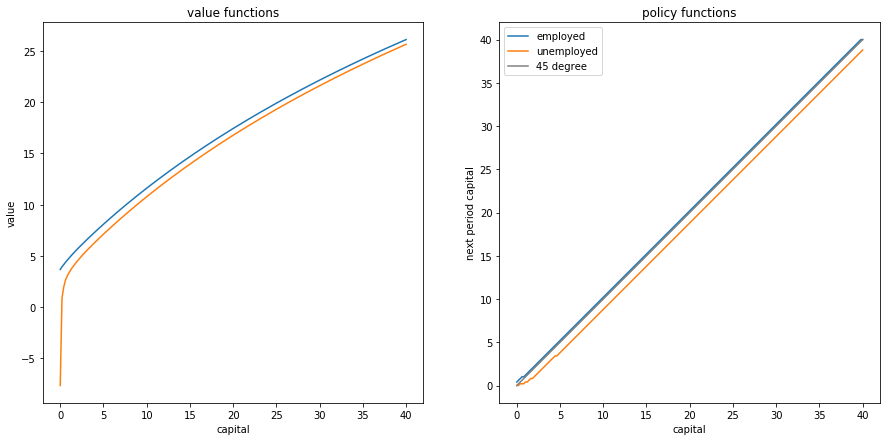

In [250]:
Pol = extract_policy(V, P_init, T, k_grid, kbar, *params1())

fig, (ax1, ax2) = plt.subplots(ncols = 2, nrows = 1, figsize = (15,7))
ax1.plot(k_grid, V[0], label = 'employed')
ax1.plot(k_grid, V[1], label = 'unemployed')
ax1.set_xlabel('capital')
ax1.set_ylabel('value')
ax1.set_title('value functions')

ax2.plot(k_grid, Pol[0], label = 'employed')
ax2.plot(k_grid, Pol[1], label = 'unemployed')
ax2.plot(k_grid, k_grid, label = '45 degree', color = 'grey')
ax2.set_xlabel('capital')
ax2.set_ylabel('next period capital')
ax2.set_title('policy functions')

plt.legend()
plt.show()

### Run simulation and calculate steady state

In [251]:
# write policy into functions
def pol1(k):
    
    func = interp1d(k_grid, Pol[0], fill_value = 'extrapolate')
    
    return func(k)

def pol2(k):
    
    func = interp1d(k_grid, Pol[1], fill_value = 'extrapolate')
    
    return func(k)

In [254]:
def simulation(length, kstart, maxiter, *params, tol = 1e-3):

    kbar, rbar, wbar, cbar = solve_SS(*params1())
    diff = np.inf
    
    # params to run iteration2convergence
    k_simu = np.zeros(length)
    ϵ = np.array([1, 0])
    V_init = np.ones((2, 200))
    P_init = np.array([0.9, 0.1])
    T = np.array([[0.9, 0.1], [0.9, 0.1]])
    np.random.seed(100)
    kbar_simu = [kbar]
    
    
    for iters in range(maxiter):
        k_simu[0] = kstart
        a = kbar - 3
        b = kbar + 3
        for i in range(1, length):
            ϵ_simu = np.random.random()
            
            if ϵ_simu > 0.1:
                ϵ_simu = 1
            else: 
                ϵ_simu = 0
                
            if ϵ_simu == 1:
                k_simu[i] = pol1(k_simu[i-1])
            else:
                k_simu[i] = pol2(k_simu[i-1])
                
#             if i % 500 == 0:
    
        kbarhat = k_simu.mean()
        print(kbarhat)
        diff = abs(kbarhat - kbar)
        
        if diff < tol:
            break
        print('iteration {} with difference {}'.format(iters + 1, diff))
        
        if kbarhat - kbar < 0:
            b = kbar
            kbar = (a + b) / 2
            
        else:
            a = kbar
            kbar = (a + b) / 2

        V = iteration2converge(V_init, P_init, k_grid, ϵ, T, kbar, 1e-6, 1000, *params, plot = False)
#         print(V)
        Pol = extract_policy(V, P_init, T, k_grid, kbar, *params1())

#         fig, ax1 = plt.subplots(ncols = 1, nrows = 1, figsize = (9,7))

#         ax1.plot(k_grid, Pol[0], label = 'employed')
#         ax1.plot(k_grid, Pol[1], label = 'unemployed')
#         ax1.plot(k_grid, k_grid, label = '45 degree', color = 'grey')
#         ax1.set_xlabel('capital')
#         ax1.set_ylabel('next period capital')
#         ax1.set_title('policy functions')

#         plt.legend()
#         plt.show()
        
    return Pol

In [255]:
Pol = simulation(10000, 5, 1000, params1())

37.7224007
iteration 1 with difference 31.23234194666047
iteration: 0 with maximum different difference 10.488244990415065
iteration: 100 with maximum different difference 0.002973640445674164
iteration: 200 with maximum different difference 4.96173334134653e-05
37.1722322
iteration 2 with difference 29.18217344666047
iteration: 0 with maximum different difference 10.873892846742883
iteration: 100 with maximum different difference 0.0037576588528018817
iteration: 200 with maximum different difference 6.338299048636031e-05
iteration: 300 with maximum different difference 1.0692913008369942e-06
37.3882958
iteration 3 with difference 27.89823704666047
iteration: 0 with maximum different difference 11.323924058347352
iteration: 100 with maximum different difference 0.0045018370684601905
iteration: 200 with maximum different difference 7.594650267606085e-05
iteration: 300 with maximum different difference 1.2812417686802746e-06
37.505855
iteration 4 with difference 26.515796246660464
iterat

37.5801343
iteration 26 with difference 0.409924453339535
iteration: 0 with maximum different difference 999999.04
iteration: 100 with maximum different difference 0.010554238688200712
iteration: 200 with maximum different difference 0.0001780533930286765
iteration: 300 with maximum different difference 3.003820893354714e-06
37.63287340000001
iteration 27 with difference 1.1428146466604758
iteration: 0 with maximum different difference 999999.04
iteration: 100 with maximum different difference 0.010786490980535746
iteration: 200 with maximum different difference 0.00018197153076471295


KeyboardInterrupt: 

In [ ]:
fig, ax1 = plt.subplots(ncols = 1, nrows = 1, figsize = (9,7))

ax1.plot(k_grid, Pol[0], label = 'employed')
ax1.plot(k_grid, Pol[1], label = 'unemployed')
ax1.plot(k_grid, k_grid, label = '45 degree', color = 'grey')
ax1.set_xlabel('capital')
ax1.set_ylabel('next period capital')
ax1.set_title('policy functions')

plt.legend()
plt.show()